In [561]:
import yfinance as yf
import pandas as pd
import os
import warnings
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

BASE_DIR="/Users/dannyyu/Desktop/AI_Trader/data"
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'INTC', 'AMD', 'IBM']
START_DATE = "2022-01-01"

def read_CSV_File(ticker,folderName):
    dir = BASE_DIR+"/"+folderName+"/"+ticker+"_"+folderName+".csv"
    table= pd.read_csv(dir,index_col=0,low_memory=False)
    return table

def plot_MACD(table, ax):
    # Plot MACD and Signal
    ax.plot(table.index, table['MACD_Line'], label='MACD', color='blue', linewidth=1.5)
    ax.plot(table.index, table['MACD_Signal'], label='Signal Line', color='red', linewidth=1.5)
    
    # Bar plot for histogram
    ax.bar(table.index, table['MACD_Histogram'], label='Histogram', color='gray', alpha=0.4, width=1)
    
    ax.set_title('MACD Indicator')
    ax.set_ylabel('MACD')
    ax.legend()
    ax.grid(True)

def plot_bollinger_band(table, ax, window=15):
    # Plot the stock price and bands
    ax.plot(table.index, table['Close'], label='Stock Price', color='blue', linewidth=1.5)
    ax.plot(table.index, table[f"Bollinger_Upper_{window}"], label='Upper Band', color='green', linewidth=1)
    ax.plot(table.index, table[f"Bollinger_Lower_{window}"], label='Lower Band', color='green', linewidth=1)
    ax.plot(table.index, table[f"Bollinger_Middle_{window}"], label='Rolling Mean', color='red', linewidth=1.5)

    # Shaded area between upper and lower band
    ax.fill_between(table.index,
                    table[f"Bollinger_Lower_{window}"],
                    table[f"Bollinger_Upper_{window}"],
                    color='gray',
                    alpha=0.2)

    ax.set_title(f'Bollinger Bands (Window = {window})')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)


In [90]:
### graph the relationship between the CLose price and technical indicators

output_path = "/Users/dannyyu/Desktop/AI_Trader/data/visualize"

for ticker in TICKERS:
    print(f"Processing {ticker}...")

    aapl = read_CSV_File(ticker, "feature")
    aapl.index = pd.to_datetime(aapl.index).tz_localize(None)
    aapl = aapl[aapl.index >= '2023-01-01']

    fig, axs = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

    # Plot 1: Close price & moving averages
    axs[0].plot(aapl.index, aapl['Close'], label='Close Price')
    axs[0].plot(aapl.index, aapl['SMA_15'], label='15-day SMA')
    axs[0].plot(aapl.index, aapl['SMA_30'], label='30-day SMA')
    axs[0].plot(aapl.index, aapl['EMA_15'], label='15-day EMA')
    axs[0].plot(aapl.index, aapl['Rolling_Median_15'], label='15-day Rolling Median')
    axs[0].set_title(f"{ticker} Price & Moving Averages")
    axs[0].legend()

    # Plot 2: RSI
    axs[1].plot(aapl.index, aapl['RSI_15'], label='RSI', color='orange')
    axs[1].axhline(70, linestyle='--', color='red')
    axs[1].axhline(30, linestyle='--', color='green')
    axs[1].set_title("RSI")

    # Plot 3: Volume
    axs[2].bar(aapl.index, aapl['Volume'], color='gray')
    axs[2].set_title("Volume")

    # Plot 4: MACD
    plot_MACD(aapl, axs[3])

    # Plot 5: Bollinger Band
    plot_bollinger_band(aapl, ax=axs[4])

    # Format x-axis ticks
    axs[4].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Save figure
    filename = f"{ticker}_technical_analysis.png"
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, filename), dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory

Processing AAPL...
Processing MSFT...
Processing GOOGL...
Processing AMZN...
Processing META...
Processing NVDA...
Processing TSLA...
Processing INTC...
Processing AMD...
Processing IBM...


In [183]:
data=read_CSV_File("AAPL", "feature")
data['Return_1d'] = data['Close'].pct_change().shift(-1)
data['Return_5d'] = (data['Close'].shift(-5) - data['Close']) / data['Close']
cols = [ 'Volume','DilutedEPS', 'PE', 'Revenue', 'CashFlow', 'EBITDA', 'GrossProfit',
       'OperatingMargin', 'ROE', 'DebtToEquity','Revenue_perShare', 'CashFlow_perShare',
       'EBITDA_perShare', 'GrossProfit_perShare', 'Lag_1', 'Lag_3', 'Lag_5',
       'SMA_15', 'SMA_30', 'Rolling_Median_15', 'EMA_15', 'EMA_30', 'RSI_15',
       'RSI_30', 'Bollinger_Middle_15', 'Bollinger_Upper_15',
       'Bollinger_Lower_15', 'MACD_Line', 'MACD_Signal', 'MACD_Histogram',
       'Volatility_20',"Close"]
data=data[cols + ['Return_5d']+["Return_1d"]].dropna()
correlation = data.corr()
corr_5d=correlation['Return_5d'].sort_values(ascending=False)
corr_1d=correlation['Return_1d'].sort_values(ascending=False)
display(corr_5d)

Return_5d               1.000000
Return_1d               0.431368
PE                      0.040445
Volume                  0.014515
Volatility_20           0.009990
DebtToEquity           -0.023691
RSI_30                 -0.040055
CashFlow_perShare      -0.041646
CashFlow               -0.042741
Revenue_perShare       -0.044764
ROE                    -0.044885
Revenue                -0.045589
GrossProfit_perShare   -0.046010
GrossProfit            -0.046732
EBITDA_perShare        -0.047163
RSI_15                 -0.047608
EBITDA                 -0.047791
OperatingMargin        -0.049602
DilutedEPS             -0.051319
MACD_Signal            -0.056674
MACD_Histogram         -0.075324
MACD_Line              -0.077217
Bollinger_Upper_15     -0.080015
SMA_30                 -0.090749
EMA_30                 -0.092506
Rolling_Median_15      -0.093172
Bollinger_Middle_15    -0.093756
SMA_15                 -0.093756
Lag_5                  -0.094310
EMA_15                 -0.098351
Lag_3     

In [231]:
ratio_cols = [
    'DilutedEPS', 'PE', 'Revenue', 'CashFlow', 'EBITDA', 'GrossProfit',
    'OperatingMargin', 'ROE', 'DebtToEquity', 'Revenue_perShare',
    'CashFlow_perShare', 'EBITDA_perShare', 'GrossProfit_perShare'
]

avg_corr=read_CSV_File("MASTER","correlation")
feature_corr = avg_corr[~avg_corr.index.isin(ratio_cols)]
feature_corr["Return_5d"]



Volume                 0.017794
Volatility_20          0.003818
MACD_Histogram        -0.011833
RSI_30                -0.016868
RSI_15                -0.032115
MACD_Signal           -0.033706
MACD_Line             -0.035424
Bollinger_Upper_15    -0.074540
Rolling_Median_15     -0.075579
SMA_30                -0.075776
EMA_30                -0.076294
SMA_15                -0.076350
Bollinger_Middle_15   -0.076350
Bollinger_Lower_15    -0.076511
Lag_3                 -0.076581
Lag_5                 -0.077684
EMA_15                -0.078278
Lag_1                 -0.079258
Close                 -0.081611
Return_5d                   NaN
Return_1d                   NaN
Name: Return_5d, dtype: float64

In [229]:
ratio_corr = avg_corr.loc[ratio_cols]
ratio_corr["Return_5d"]

DilutedEPS              0.008395
PE                      0.020303
Revenue                -0.007863
CashFlow               -0.004623
EBITDA                  0.007285
GrossProfit            -0.008743
OperatingMargin        -0.002284
ROE                    -0.003244
DebtToEquity            0.007599
Revenue_perShare       -0.025495
CashFlow_perShare      -0.028002
EBITDA_perShare        -0.022916
GrossProfit_perShare   -0.027648
Name: Return_5d, dtype: float64

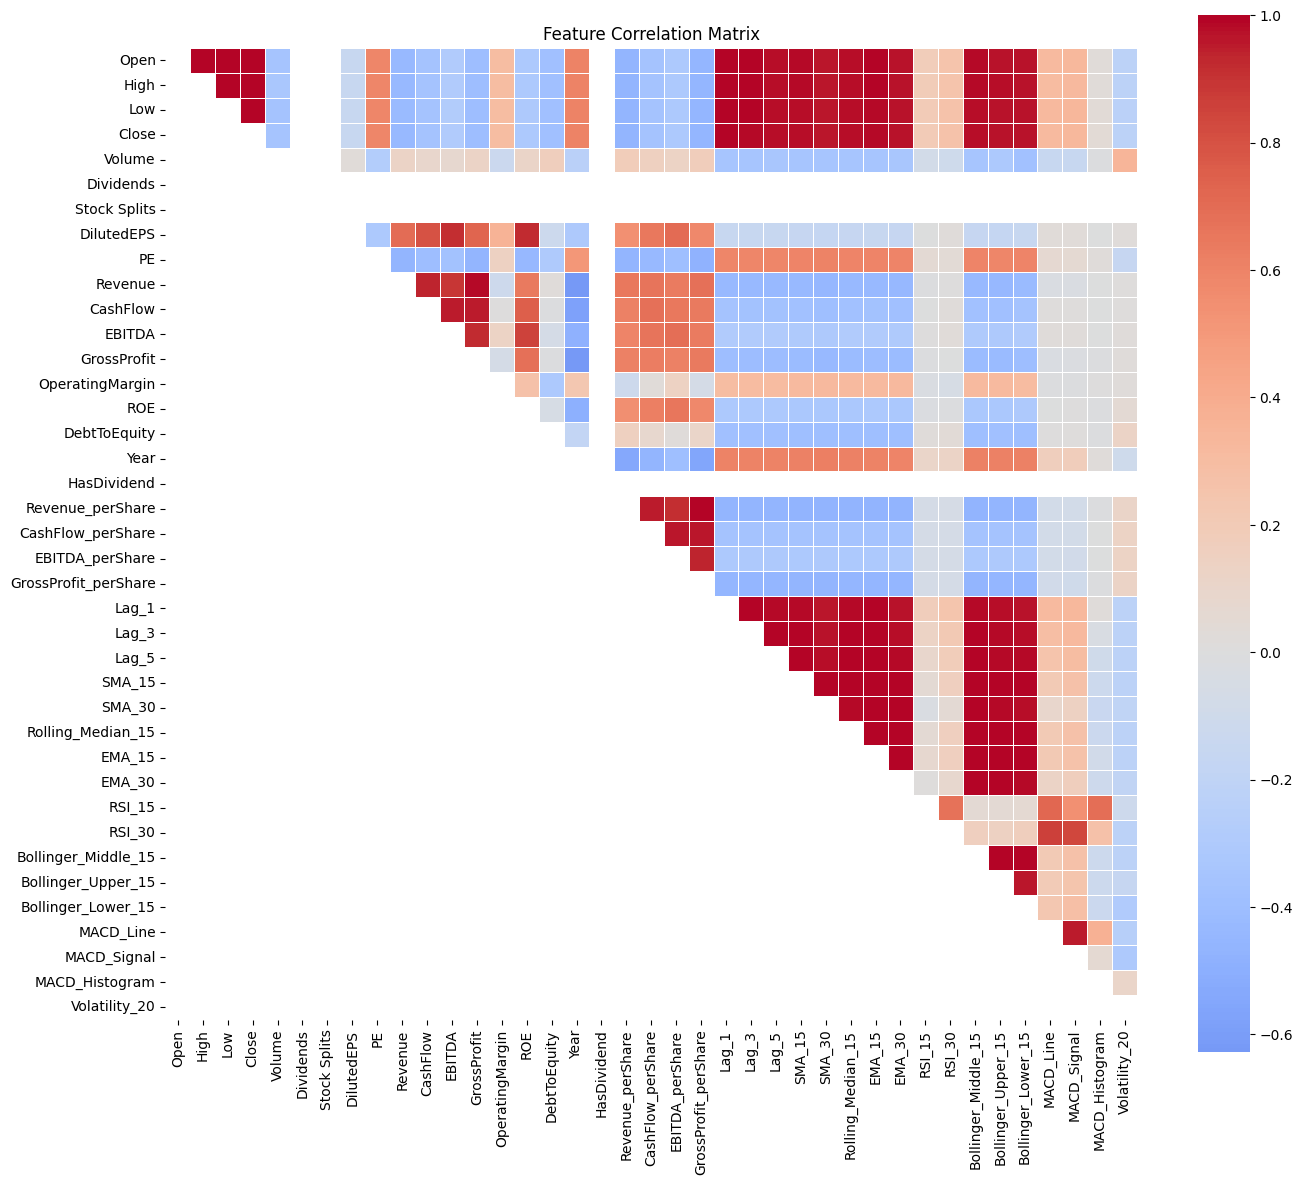

In [307]:
### find the correlation between features to detect Multicollinearity


correlation_matrices = []

for ticker in TICKERS:
    data = read_CSV_File(ticker,"feature")
    numeric_features = data.select_dtypes(include='number')
    corr_matrix = numeric_features.corr()
    correlation_matrices.append(corr_matrix)

# Ensure all matrices have the same index/column order
base_index = correlation_matrices[0].index
correlation_matrices = [df.loc[base_index, base_index] for df in correlation_matrices]

    # Stack into 3D numpy array
stacked = np.stack([df.values for df in correlation_matrices])

    # Compute mean along axis 0
avg_matrix = np.mean(stacked, axis=0)

    # Convert back to DataFrame
avg_corr = pd.DataFrame(avg_matrix, index=base_index, columns=base_index)
mask = np.tril(np.ones(avg_corr.shape)).astype(bool)
avg_corr = avg_corr.mask(mask)

plt.figure(figsize=(14, 12))
sb.heatmap(avg_corr, cmap='coolwarm', center=0, annot=False, fmt=".2f", square=True, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

output_path = "/Users/dannyyu/Desktop/AI_Trader/data/visualize"
filename="Correlation_between_features"
plt.savefig(os.path.join(output_path, filename), dpi=300, bbox_inches='tight')


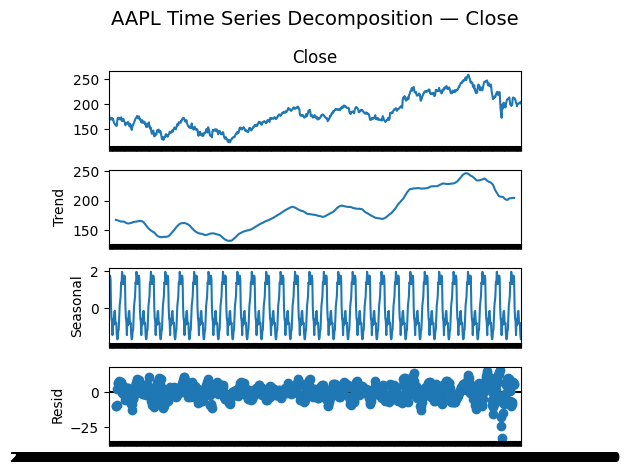

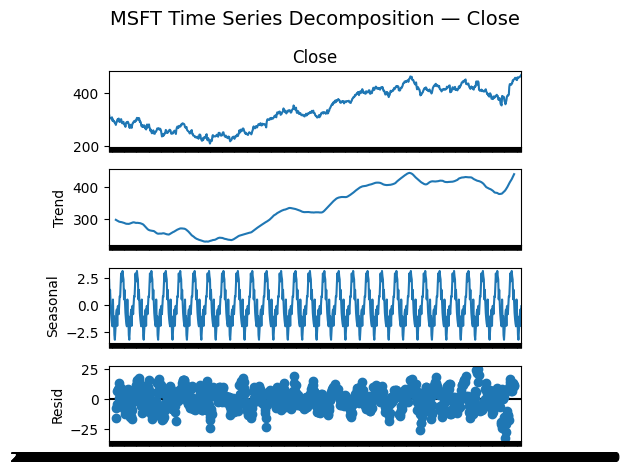

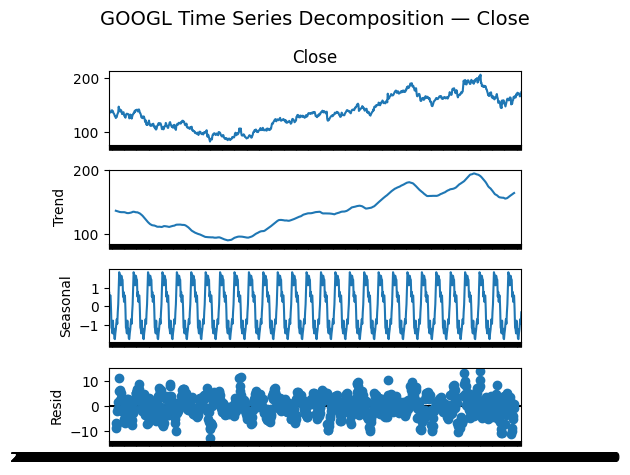

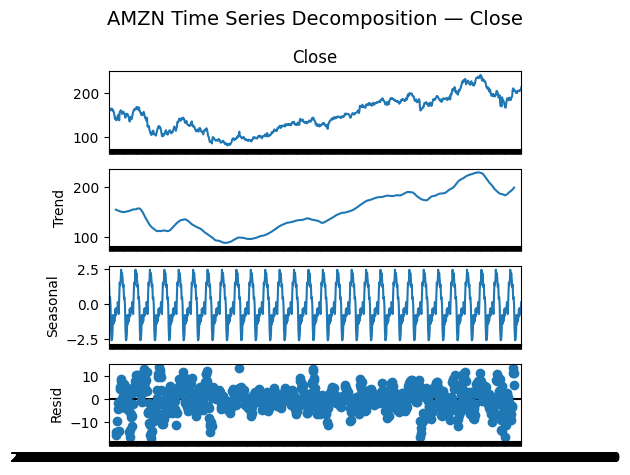

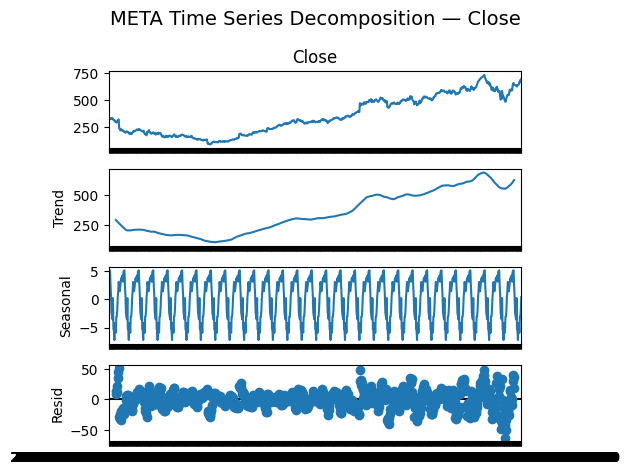

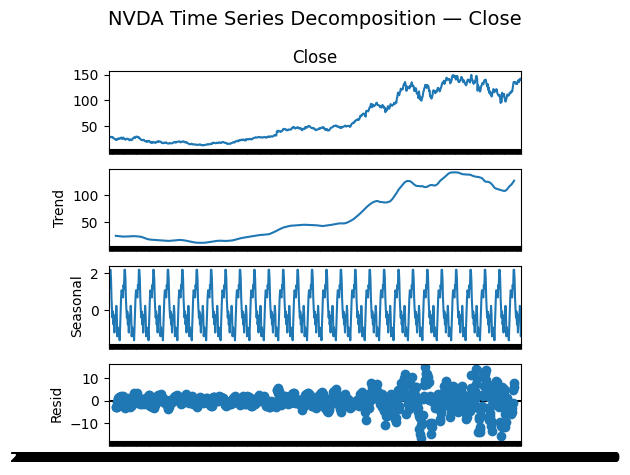

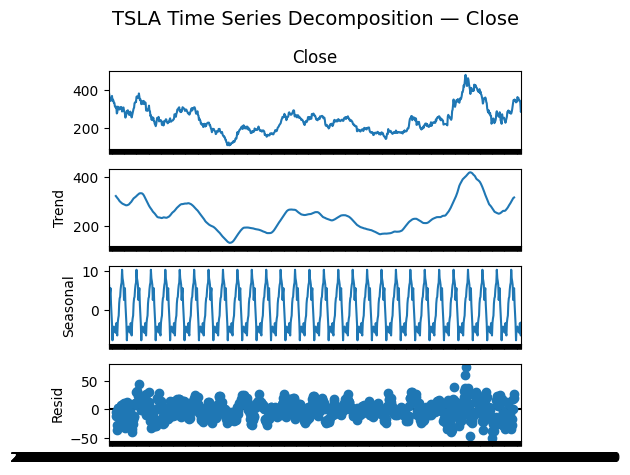

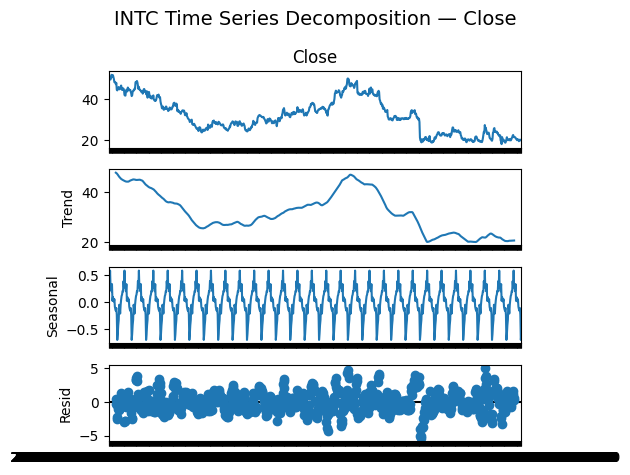

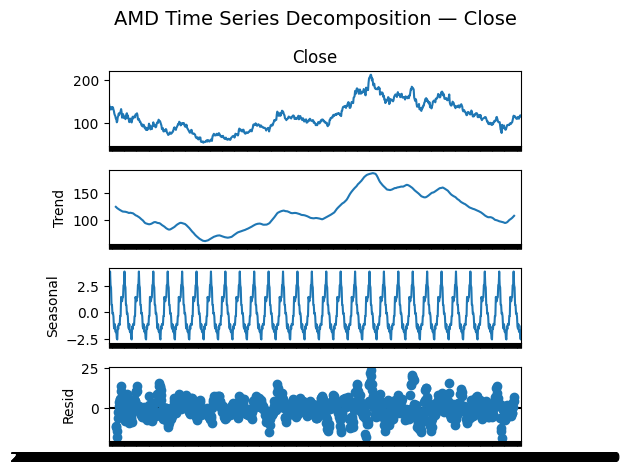

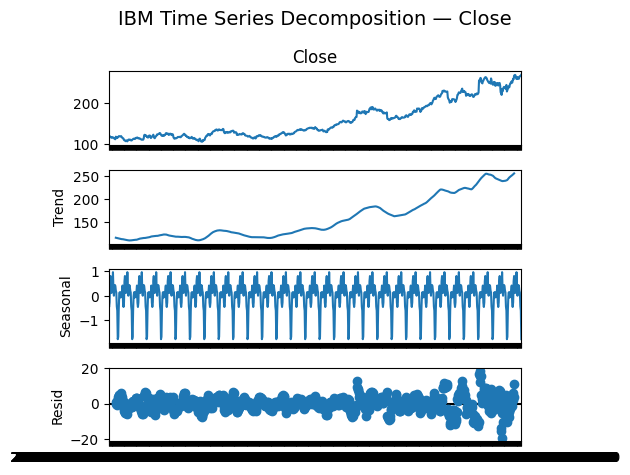

In [340]:
### saves the time series analysis diagram for all data
for ticker in TICKERS:
    data=read_CSV_File(ticker,"feature")
    series = data['Close'].dropna()
    result = seasonal_decompose(series, model='additive', period=30)
    result.plot()
    plt.suptitle(f"{ticker} Time Series Decomposition — Close", fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, f'{ticker}_timeSeries'), dpi=300, bbox_inches='tight')



In [334]:
### adding the Return column and the seasonality feature to the data table

for ticker in TICKERS:
    print(f"Processing {ticker}")
    data=read_CSV_File(ticker,"feature")
    data['Return_1d'] = data['Close'].pct_change().shift(-1)
    data['Return_5d'] = (data['Close'].shift(-5) - data['Close']) / data['Close']
        
    series = data['Close'].dropna()
    result = seasonal_decompose(series, model='additive', period=30)
    data['Close_Seasonal'] = result.seasonal
    data.to_csv(os.path.join(BASE_DIR, "feature", f"{ticker}_feature.csv"), index=True)

print("Done")

Processing AAPL
Processing MSFT
Processing GOOGL
Processing AMZN
Processing META
Processing NVDA
Processing TSLA
Processing INTC
Processing AMD
Processing IBM
Done


In [348]:
def combine_feature_files(folderName="feature"):
    combined=[]
    for file in os.listdir(os.path.join(BASE_DIR, folderName)):
        if file.endswith("_feature.csv") and file!= "MASTER_feature.csv":
            ticker = file.split("_")[0]
            df = read_CSV_File(ticker, folderName)
            combined.append(df)

    if combined:
        master_df = pd.concat(combined, ignore_index=False)
        return master_df
    else:
        print("error occured")
        return None

master = combine_feature_files(folderName="feature")
master.to_csv(os.path.join(BASE_DIR, "feature", "MASTER_feature.csv"), index=True)

In [584]:
### fitting to model
data=read_CSV_File("MASTER","feature")

# 1. Regression for Close, and return 1 day/ return 5 day
#   - Close
feature_set1 = [
    'Lag_1',
    'EMA_15',
    'MACD_Signal',
    'RSI_15',
    'Volume',
    'PE',
    'OperatingMargin',
    'DilutedEPS',  # or CashFlow_perShare
    'Volatility_20']
feature_set2 = [
    'Lag_1',
    'EMA_15',
    'MACD_Signal',
    'RSI_15',
    'Volume',
    'PE',
    'OperatingMargin',
    'CashFlow_perShare', 
    'Volatility_20']
feature_set3 = [
    'Lag_5',
    'EMA_15',
    'MACD_Signal',
    'RSI_15',
    'Volume',
    'PE',
    'OperatingMargin',
    'DilutedEPS',  # or CashFlow_perShare
    'Volatility_20']
feature_set4 = [
    'Lag_1',
    'EMA_15',
    'MACD_Signal',
    'RSI_15',
    'Volume',
    'PE',
    'OperatingMargin',
    'CashFlow_perShare', 
    'Volatility_20',
    'Close_Seasonal'
]
X1 = data[feature_set1]
X2 = data[feature_set2]
X3 = data[feature_set3]
X4 = data[feature_set4]
y = data['Close'] 

# Function to evaluate model
def evaluate_model(X, y, name="Model"):
    print("Training model "+name)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    
    return {"Model": name, "R²": r2, "RMSE": rmse}
# Evaluate all 4 feature sets
results = []

results.append(evaluate_model(X1, y, name="Feature Set 1"))
results.append(evaluate_model(X2, y, name="Feature Set 2"))
results.append(evaluate_model(X3, y, name="Feature Set 3"))
results.append(evaluate_model(X4, y, name="Feature Set 4"))

# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)


Training model Feature Set 1
Training model Feature Set 2
Training model Feature Set 3
Training model Feature Set 4


,Model,R²,RMSE
0,Feature Set 1,0.986877,8.609104
1,Feature Set 2,0.987213,8.498333
2,Feature Set 3,0.978182,11.100790
3,Feature Set 4,0.986789,8.638021


In [576]:
### Computes the importance for feature set
"""
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()
"""

'\nX_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)\nmodel = RandomForestRegressor(random_state=42)\nmodel.fit(X_train, y_train)\nimportances = model.feature_importances_\nimportance_df = pd.DataFrame({\n    "Feature": X_train.columns,\n    "Importance": importances\n}).sort_values(by="Importance", ascending=False)\nplt.figure(figsize=(10, 6))\nplt.barh(importance_df["Feature"], importance_df["Importance"])\nplt.gca().invert_yaxis()\nplt.title("Feature Importance")\nplt.xlabel("Importance Score")\nplt.tight_layout()\nplt.show()\n'

In [586]:
### graph the predict Close price vs actual close price
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, shuffle=False)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_test_series = pd.Series(y_test, index=X_test.index)
y_pred_series = pd.Series(y_pred, index=X_test.index)

Date
2022-01-03 05:00:00+00:00    144.301605
2022-01-04 05:00:00+00:00    143.712433
2022-01-05 05:00:00+00:00    137.119446
2022-01-06 05:00:00+00:00    137.092072
2022-01-07 05:00:00+00:00    136.365036
                                ...    
2025-06-02 04:00:00+00:00    342.690002
2025-06-03 04:00:00+00:00    344.269989
2025-06-04 04:00:00+00:00    332.049988
2025-06-05 04:00:00+00:00    284.700012
2025-06-06 04:00:00+00:00    295.140015
Name: Close, Length: 1720, dtype: float64

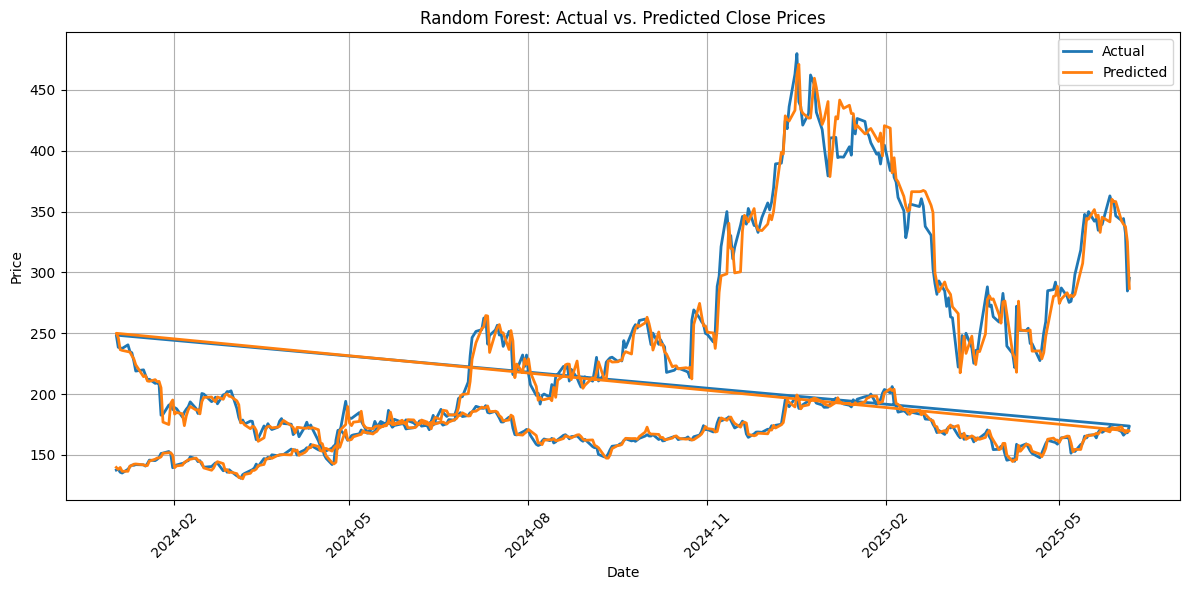

In [603]:
y_test_series.index = pd.to_datetime(y_test_series.index).tz_localize(None)
y_pred_series.index = pd.to_datetime(y_pred_series.index).tz_localize(None)
y_test_series = y_test_series[y_test_series.index >= '2024-01-01']
y_pred_series = y_pred_series[y_pred_series.index >= '2024-01-01']

plt.figure(figsize=(12, 6))
plt.plot(y_test_series, label="Actual", linewidth=2)
plt.plot(y_pred_series, label="Predicted", linewidth=2)
ax = plt.gca()  # get current axes
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # tick every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # format YYYY-MM

plt.xticks(rotation=45)
plt.title("Random Forest: Actual vs. Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'random_forest_Close_price'), dpi=300, bbox_inches='tight')
plt.show()


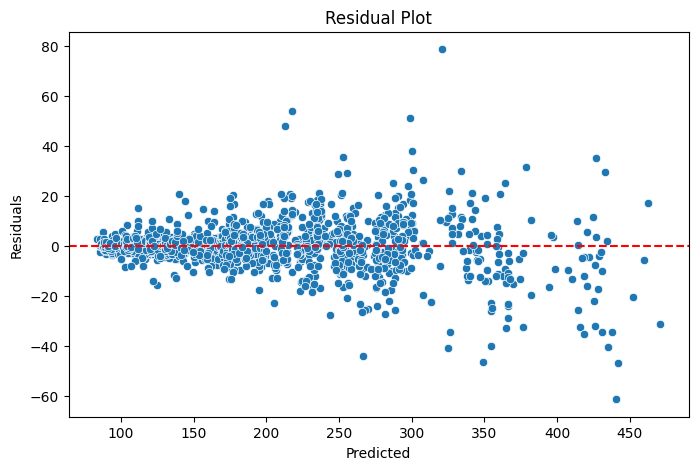

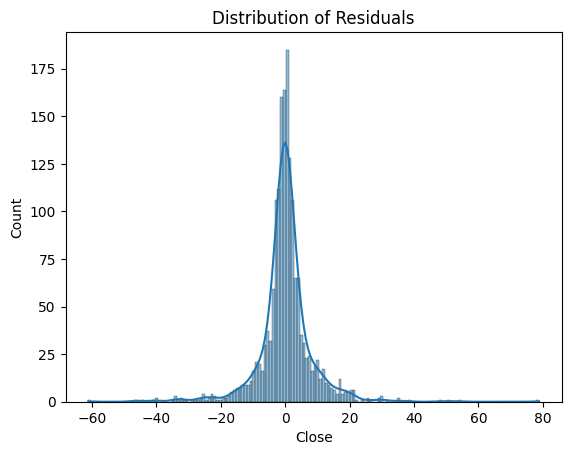

In [408]:
### Computes Residual
y_pred = model.predict(X_test)
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sb.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.savefig(os.path.join(output_path, 'Predict_Close_model2_residual'), dpi=200, bbox_inches='tight')
plt.show()
sb.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.savefig(os.path.join(output_path, 'Predict_Close_model2_residual_distribution'), dpi=300, bbox_inches='tight')

In [419]:
### Cross Validation
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X2, y, cv=tscv, scoring='r2')
print("Cross-validated R² scores:", scores)
print("Mean R²:", scores.mean())

Cross-validated R² scores: [0.82605124 0.91506976 0.40112684 0.98362761 0.98376627]
Mean R²: 0.8219283444464367


In [469]:
### predicting return
features_set1 = [
    "Close",
    'Lag_1', 
    'Lag_5',
    'SMA_30',
    'EMA_15',
    'Bollinger_Middle_15',
    'MACD_Signal',
    'RSI_15',
    'Volume',
    'PE',
    'ROE',
    'Volatility_20' ]
feature_set2 = [
    'Lag_1', 
    'Lag_5',
    'Volume', 
    'PE', 
    'ROE', 
    'Volatility_20',
    'CashFlow_perShare', 
    'OperatingMargin'
]
feature_set3 = [
    'SMA_30',
    'EMA_15',
    'Bollinger_Middle_15',
    'MACD_Signal',
    'RSI_15',
    'Volume',
    'PE',
    'ROE',
    'Volatility_20',
    'Close_Seasonal'
]
data = data.dropna(subset=['Return_1d', 'Return_5d'])
X1 = data[feature_set1]
X2 = data[feature_set2]
X3 = data[feature_set3]
y1 = data['Return_1d'] 
y5 = data["Return_5d"]

def evaluate_return(X,y,name="Model"):
    print("Training model:", name)
    
    # Use time-based split (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Fit model
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    
    return {
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "Features": X_train.columns.tolist()
    }

results = []



results.append(evaluate_return(X1, y1, name="1 Day Return w/ Feature Set 1"))
results.append(evaluate_return(X2, y1, name="1 Day Return w/ Feature Set 2"))
results.append(evaluate_return(X3, y1, name="1 Day Return w/ Feature Set 3"))
results.append(evaluate_return(X1, y5, name="5 Day Return w/ Feature Set 1"))
results.append(evaluate_return(X2, y5, name="5 Day Return w/ Feature Set 2"))
results.append(evaluate_return(X3, y5, name="5 Day Return w/ Feature Set 3"))


# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)



Training model: 1 Day Return w/ Feature Set 1
Training model: 1 Day Return w/ Feature Set 2
Training model: 1 Day Return w/ Feature Set 3
Training model: 5 Day Return w/ Feature Set 1
Training model: 5 Day Return w/ Feature Set 2
Training model: 5 Day Return w/ Feature Set 3


,Model,R²,RMSE,MAE,Features
0,1 Day Return w/ Feature Set 1,-0.112225,0.033665,0.023524,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
1,1 Day Return w/ Feature Set 2,-0.062988,0.032911,0.023157,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
2,1 Day Return w/ Feature Set 3,-0.147038,0.034187,0.024014,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."
3,5 Day Return w/ Feature Set 1,-0.208958,0.078974,0.056743,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
4,5 Day Return w/ Feature Set 2,-0.142027,0.076757,0.056251,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
5,5 Day Return w/ Feature Set 3,-0.111690,0.075731,0.055154,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."


In [477]:
### test linear regression model for predicting return
data = data.dropna()
X1 = data[feature_set1]
X2 = data[feature_set2]
X3 = data[feature_set3]
y1 = data['Return_1d'] 
y5 = data["Return_5d"]
def evaluate_linear_regression(X, y, name="Linear Regression"):
    print("Training model:", name)
    
    # Time-based split (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Initialize and fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    
    return {
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "Features": X_train.columns.tolist()
    }
    
results = []

results.append(evaluate_linear_regression(X1, y1, name="1 Day Return w/ Feature Set 1"))
results.append(evaluate_linear_regression(X2, y1, name="1 Day Return w/ Feature Set 2"))
results.append(evaluate_linear_regression(X3, y1, name="1 Day Return w/ Feature Set 3"))
results.append(evaluate_linear_regression(X1, y5, name="5 Day Return w/ Feature Set 1"))
results.append(evaluate_linear_regression(X2, y5, name="5 Day Return w/ Feature Set 2"))
results.append(evaluate_linear_regression(X3, y5, name="5 Day Return w/ Feature Set 3"))


# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)

Training model: 1 Day Return w/ Feature Set 1
Training model: 1 Day Return w/ Feature Set 2
Training model: 1 Day Return w/ Feature Set 3
Training model: 5 Day Return w/ Feature Set 1
Training model: 5 Day Return w/ Feature Set 2
Training model: 5 Day Return w/ Feature Set 3


,Model,R²,RMSE,MAE,Features
0,1 Day Return w/ Feature Set 1,-0.002299,0.031870,0.022321,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
1,1 Day Return w/ Feature Set 2,-0.001014,0.031850,0.022311,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
2,1 Day Return w/ Feature Set 3,0.000881,0.031820,0.022324,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."
3,5 Day Return w/ Feature Set 1,-0.004079,0.072299,0.052668,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
4,5 Day Return w/ Feature Set 2,-0.005406,0.072347,0.052752,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
5,5 Day Return w/ Feature Set 3,0.014234,0.071637,0.052146,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."


In [496]:
def evaluate_xgboost(X, y, name="XGBoost"):
    print("Training model:", name)
    
    # Time-based split (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Initialize and fit XGBoost model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0  # silence training logs
    )
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    
    return {
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "Features": X_train.columns.tolist()
    }

results = []

results.append(evaluate_xgboost(X1, y1, name="1 Day Return w/ Feature Set 1"))
results.append(evaluate_xgboost(X2, y1, name="1 Day Return w/ Feature Set 2"))
results.append(evaluate_xgboost(X3, y1, name="1 Day Return w/ Feature Set 3"))
results.append(evaluate_xgboost(X1, y5, name="5 Day Return w/ Feature Set 1"))
results.append(evaluate_xgboost(X2, y5, name="5 Day Return w/ Feature Set 2"))
results.append(evaluate_xgboost(X3, y5, name="5 Day Return w/ Feature Set 3"))


# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)

Training model: 1 Day Return w/ Feature Set 1
Training model: 1 Day Return w/ Feature Set 2
Training model: 1 Day Return w/ Feature Set 3
Training model: 5 Day Return w/ Feature Set 1
Training model: 5 Day Return w/ Feature Set 2
Training model: 5 Day Return w/ Feature Set 3


,Model,R²,RMSE,MAE,Features
0,1 Day Return w/ Feature Set 1,-0.061700,0.032801,0.022776,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
1,1 Day Return w/ Feature Set 2,-0.042626,0.032505,0.022775,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
2,1 Day Return w/ Feature Set 3,-0.100360,0.033393,0.023483,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."
3,5 Day Return w/ Feature Set 1,-0.123310,0.076471,0.055027,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
4,5 Day Return w/ Feature Set 2,-0.058977,0.074249,0.053652,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
5,5 Day Return w/ Feature Set 3,-0.093721,0.075457,0.054509,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."


In [541]:
### using time series model to predict return
data=read_CSV_File("MASTER","feature")
data.index = pd.to_datetime(data.index)
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X1 = data[feature_set1]
X2 = data[feature_set2]
X3 = data[feature_set3]
y1 = data['Return_1d'] 
y5 = data["Return_5d"]


def evaluate_sarimax(X, y, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), name="SARIMAX"):
    print("Training model:", name)
    X = X.sort_index()
    y = y.sort_index()
    # Ensure the index is datetime for time series modeling
    if not isinstance(X.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex for time series models.")

    # Use 80% training, 20% testing (time-based split)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    
    # Fit SARIMAX model (endog = y, exog = X)
    model = SARIMAX(endog=y_train, exog=X_train,
                    order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    
    results = model.fit(disp=False)
    
    # Predict
    start_idx = len(y_train)
    end_idx = start_idx + len(y_test) - 1
    
    pred = results.get_prediction(start=start_idx, end=end_idx, exog=X_test)
    y_pred = pred.predicted_mean

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)

    return {
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "Features": X_train.columns.tolist()
    }
results = []

results.append(evaluate_sarimax(X1, y1, name="1 Day Return w/ Feature Set 1"))
results.append(evaluate_sarimax(X2, y1, name="1 Day Return w/ Feature Set 2"))
results.append(evaluate_sarimax(X3, y1, name="1 Day Return w/ Feature Set 3"))
results.append(evaluate_sarimax(X1, y5, name="5 Day Return w/ Feature Set 1"))
results.append(evaluate_sarimax(X2, y5, name="5 Day Return w/ Feature Set 2"))
results.append(evaluate_sarimax(X3, y5, name="5 Day Return w/ Feature Set 3"))


# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)

Training model: 1 Day Return w/ Feature Set 1
Fitting model with X_train: (6600, 9), y_train: (6600,)


/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

Training model: 1 Day Return w/ Feature Set 2
Fitting model with X_train: (6600, 8), y_train: (6600,)


/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

Training model: 1 Day Return w/ Feature Set 3
Fitting model with X_train: (6600, 10), y_train: (6600,)


/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

Training model: 5 Day Return w/ Feature Set 1
Fitting model with X_train: (6600, 9), y_train: (6600,)


/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored 

Training model: 5 Day Return w/ Feature Set 2
Fitting model with X_train: (6600, 8), y_train: (6600,)


/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Training model: 5 Day Return w/ Feature Set 3
Fitting model with X_train: (6600, 10), y_train: (6600,)


/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannyyu/Desktop/AI_Trader/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at 

,Model,R²,RMSE,MAE,Features
0,1 Day Return w/ Feature Set 1,-0.001777,0.030570,0.020073,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
1,1 Day Return w/ Feature Set 2,-0.000555,0.030552,0.020062,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
2,1 Day Return w/ Feature Set 3,-0.000169,0.030546,0.020069,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."
3,5 Day Return w/ Feature Set 1,-0.017379,0.067021,0.047965,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
4,5 Day Return w/ Feature Set 2,-0.006609,0.066665,0.047835,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
5,5 Day Return w/ Feature Set 3,-0.006278,0.066654,0.047649,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."


In [552]:
### testing mlp (neural net) for predicting return

data=read_CSV_File("MASTER","feature")
data.index = pd.to_datetime(data.index)
data = data.replace([np.inf, -np.inf], np.nan).dropna()
X1 = data[feature_set1]
X2 = data[feature_set2]
X3 = data[feature_set3]
y1 = data['Return_1d'] 
y5 = data["Return_5d"]

def evaluate_mlp(X, y, name="MLP Regressor"):
    print("Training model:", name)

    # Time-based split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit MLP model
    model = MLPRegressor(hidden_layer_sizes=(64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=500,
                         random_state=42)
    
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)

    # Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)

    return {
        "Model": name,
        "R²": r2,
        "RMSE": rmse,
        "MAE": mae,
        "Features": X_train.columns.tolist()
    }

results = []

results.append(evaluate_mlp(X1, y1, name="1 Day Return w/ Feature Set 1"))
results.append(evaluate_mlp(X2, y1, name="1 Day Return w/ Feature Set 2"))
results.append(evaluate_mlp(X3, y1, name="1 Day Return w/ Feature Set 3"))
results.append(evaluate_mlp(X1, y5, name="5 Day Return w/ Feature Set 1"))
results.append(evaluate_mlp(X2, y5, name="5 Day Return w/ Feature Set 2"))
results.append(evaluate_mlp(X3, y5, name="5 Day Return w/ Feature Set 3"))

# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)

Training model: 1 Day Return w/ Feature Set 1
Training model: 1 Day Return w/ Feature Set 2
Training model: 1 Day Return w/ Feature Set 3
Training model: 5 Day Return w/ Feature Set 1
Training model: 5 Day Return w/ Feature Set 2
Training model: 5 Day Return w/ Feature Set 3


,Model,R²,RMSE,MAE,Features
0,1 Day Return w/ Feature Set 1,-2.224343,0.057162,0.040993,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
1,1 Day Return w/ Feature Set 2,-1.831239,0.053564,0.038868,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
2,1 Day Return w/ Feature Set 3,-2.076503,0.055836,0.039750,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."
3,5 Day Return w/ Feature Set 1,-0.602277,0.091331,0.065256,"[Lag_1, EMA_15, MACD_Signal, RSI_15, Volume, P..."
4,5 Day Return w/ Feature Set 2,-0.664116,0.093077,0.072416,"[Lag_1, Lag_5, Volume, PE, ROE, Volatility_20,..."
5,5 Day Return w/ Feature Set 3,-0.699900,0.094072,0.068249,"[SMA_30, EMA_15, Bollinger_Middle_15, MACD_Sig..."


In [611]:
### predict categorical up or down

from sklearn.preprocessing import OrdinalEncoder
def categorize_return(r):
    if r> 0.0:
        return "Up"
    else:
        return "Down"
    
    """if r > 0.05:
        return 'Strong Up'
    elif r > 0:
        return 'Weak Up'
    elif r > -0.05:
        return 'Weak Down'
    else:
        return 'Strong Down' """

        
data=read_CSV_File("MASTER","feature")
data["UpDown_5d"]=data['Return_5d'].apply(categorize_return)
encoder = OrdinalEncoder()
data["UpDown_5d"]=encoder.fit_transform(data[['UpDown_5d']])

data["UpDown_1d"]=data['Return_1d'].apply(categorize_return)
encoder = OrdinalEncoder()
data["UpDown_1d"]=encoder.fit_transform(data[['UpDown_1d']])
X1 = data[feature_set1]
X2 = data[feature_set2]
X3 = data[feature_set3]
y = data['UpDown_1d'] 

def evaluate_random_forest_classifier(X, y, name="Random Forest"):
    print("Training model:", name)
    
    # Time-based train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Initialize model
    model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    return {
        "Model": name,
        "Accuracy": acc,
        "F1 (macro)": report["macro avg"]["f1-score"],
        "F1 (weighted)": report["weighted avg"]["f1-score"],
        "Confusion Matrix": cm.tolist()
    }

results = []

results.append(evaluate_random_forest_classifier(X1, y, name="1 day UpDown w/ Feature Set 1"))
results.append(evaluate_random_forest_classifier(X2, y, name="1 day UpDown w/ Feature Set 2"))
results.append(evaluate_random_forest_classifier(X3, y, name="1 day UpDown w/ Feature Set 3"))


# Convert to DataFrame for display
results_df = pd.DataFrame(results)
display(results_df)

Training model: 5 day UpDown w/ Feature Set 1
Training model: 5 day UpDown w/ Feature Set 2
Training model: 5 day UpDown w/ Feature Set 3


,Model,Accuracy,F1 (macro),F1 (weighted),Confusion Matrix
0,5 day UpDown w/ Feature Set 1,0.513953,0.507426,0.508943,"[[343, 494], [342, 541]]"
1,5 day UpDown w/ Feature Set 2,0.524419,0.510895,0.513071,"[[308, 529], [289, 594]]"
2,5 day UpDown w/ Feature Set 3,0.504070,0.484272,0.486974,"[[265, 572], [281, 602]]"


In [573]:
results_df.to_csv(os.path.join(BASE_DIR, "random_forest_updown.csv"), index=False)